# Description

This section is for training the VAE implemented in the VAE.py file

# Imports

In [1]:
import torch
import math
import torch.nn as nn
from loss_function import vae_loss
from torchvision import transforms
import numpy as np
from dataset import PatternDB
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from VAE import VAE


# Start

In [2]:
DATA_PATH = "../fixed"
BATCH_SIZE = 32
INPUT_SHAPE = 2048

In [3]:
transform = transforms.Compose([
    transforms.Resize((INPUT_SHAPE, INPUT_SHAPE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset = PatternDB(data_path=DATA_PATH, transform=transform)

In [5]:
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
vae = VAE(input_size=INPUT_SHAPE, in_channel=3, latent_space_dim=[8192], device=device, features=[16, 32, 64, 128, 256, 512, 1024, 2048, 4096])

Bottleneck size: 8192


In [8]:
def smooth_beta_schedule(current_epoch, total_epochs):
   
    x = 10 * (current_epoch / total_epochs - 0.5)
    return 1 / (1 + math.exp(-x))

In [9]:
def train_one(model, loss_fn, optimizer, dataloader, device, total_epochs, current_epoch):

    running_loss = 0.0
    beta = smooth_beta_schedule(current_epoch, total_epochs)

    for i, data in enumerate(dataloader):

        optimizer.zero_grad()
        data = data.to(device)

        mu, log_var = model.encode(data)


        z = model._reparameterize(mu, log_var)


        reconstructed = model.decode(z)


        loss, perceptual_loss, kl_loss = loss_fn(data, reconstructed, mu, log_var)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


        running_loss+=loss.item()
       # print(f"Batch {i+1} loss: {loss.item()}")
      #  torch.cuda.empty_cache()
    return running_loss/len(dataloader), perceptual_loss, kl_loss


In [10]:
def train(model, train_loader, loss_fn, optimizer, device, epochs):


    model.to(device)


    for epoch in range(epochs):

        print(f'EPOCH {epoch+1}:')

        model.train(True)
        avg_loss, perceptual_loss, kl_loss = train_one(model, loss_fn, optimizer, dataloader, device, epochs, epoch+1)
        print(f'Average loss: {avg_loss}  Last perceptual loss: {perceptual_loss} Last KL loss: {kl_loss}\n\n')

        if epoch+1 % 10 == 0:
            torch.save(model.state_dict(), f"vae_model_epoch_{epoch+1}")


In [11]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-4, eps=1e-8)
loss_fn = vae_loss()

In [ ]:
train(vae, dataloader, loss_fn, optimizer, device, epochs=500)

In [13]:
torch.save(vae.state_dict(), 'vae_model.pth')

In [14]:
def show_reconstructed_images(original, reconstructed, n_images=5):
    # Move tensors to CPU for plotting (if they are on GPU)
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    # Denormalize images: Revert the normalization (mean = 0.5, std = 0.5)
    original = (original * 0.5) + 0.5  # Denormalize
    reconstructed = (reconstructed * 0.5) + 0.5  # Denormalize

    # Clip values to [0, 1] to avoid artifacts due to denormalization
    original = np.clip(original, 0, 1)
    reconstructed = np.clip(reconstructed, 0, 1)

    # Plotting
    fig, axes = plt.subplots(2, n_images, figsize=(10, 4))

    for i in range(n_images):
        # Original Image
        axes[0, i].imshow(original[i].transpose(1, 2, 0))  # [C, H, W] -> [H, W, C]
        axes[0, i].axis('off')

        # Reconstructed Image
        axes[1, i].imshow(reconstructed[i].transpose(1, 2, 0))  # [C, H, W] -> [H, W, C]
        axes[1, i].axis('off')

    plt.show()


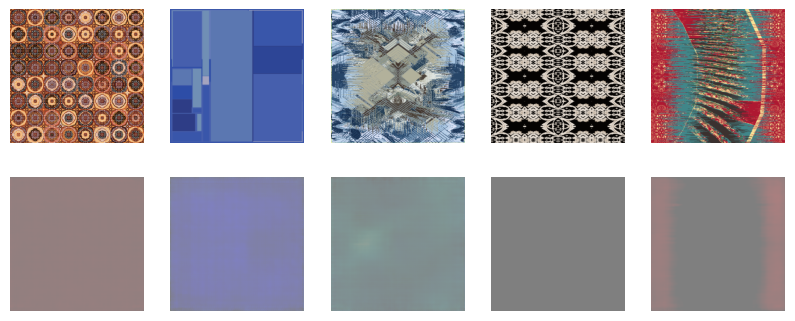

In [22]:
def display_images(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get a batch of data from the dataloader
        data_batch = next(iter(dataloader)).to(device)

        # Pass the data through the VAE model
        mu, log_var = model.encode(data_batch)
        z = model._reparameterize(mu, log_var)
        reconstructed = model.decode(z)

        # Show the original and reconstructed images
        show_reconstructed_images(data_batch, reconstructed)

# Example usage:
display_images(vae, dataloader, device)
